In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [62]:
import time
import numpy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

In [36]:
d_train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", 
                      encoding='latin1')
d_test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv", 
                     encoding='latin1')

In [6]:
d_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
d_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


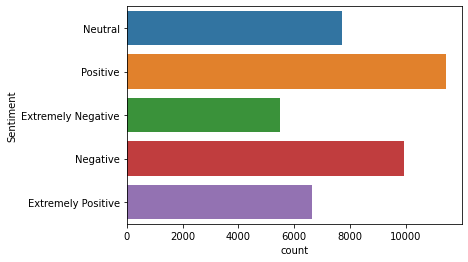

In [12]:
sns.countplot(y=d_train.Sentiment)
#degrees = 90
#plt.xticks(rotation=degrees)
plt.show()

In [14]:
# Check Nan
d_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [15]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [37]:
# Remove unused column
d_train = d_train.drop(['Location','TweetAt','ScreenName'], axis=1)
d_test = d_test.drop(['Location','TweetAt','ScreenName'], axis=1)

d_train.head()

,UserName,OriginalTweet,Sentiment
0,3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,advice Talk to your neighbours family to excha...,Positive
2,3801,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,My food stock is not the only one which is emp...,Positive
4,3803,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [38]:
# Convert sentiment into Positive = 2 , Neutral = 1 , Negative =  0
def convert_Sentiment(label):
    if label == "Extremely Positive":
        return 2
    elif label == "Extremely Negative":
        return 0
    elif label == "Positive":
        return 2
    elif label == "Negative":
        return 0
    else:
        return 1
    
# Apply convert_Sentiment function
d_train.Sentiment = d_train.Sentiment.apply(lambda x : convert_Sentiment(x))
d_train.head()

,UserName,OriginalTweet,Sentiment
0,3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,advice Talk to your neighbours family to excha...,2
2,3801,Coronavirus Australia: Woolworths to give elde...,2
3,3802,My food stock is not the only one which is emp...,2
4,3803,"Me, ready to go at supermarket during the #COV...",0


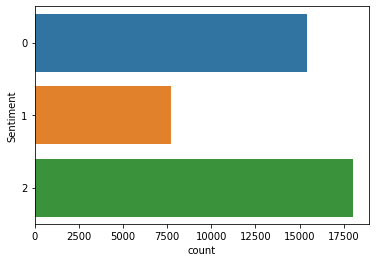

In [25]:
sns.countplot(y=d_train.Sentiment)
#degrees = 90
#plt.xticks(rotation=degrees)
plt.show()

### NLP

In [48]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

d_train['preprocessing_results'] = d_train['OriginalTweet'].apply(lambda x: cleaning_text(x))

In [49]:
for i in range(5):
    print('----------------------------------------------')
    random_number=np.random.randint(0,len(d_train)-1)
    print(d_train.preprocessing_results[random_number])
    print('----------------------------------------------\n')

----------------------------------------------
Thing I said Middle Brother Were going grocery store see find milk I refuse let panic take life acknowledge life weird right now That place life still relatively unchanged thus far
----------------------------------------------

----------------------------------------------
Freeze rent bills mortgage cut land house prices let australian breathe Why people withdraw hard earned money super What joke government Means want us work till die
----------------------------------------------

----------------------------------------------
That happened COVID 19 Which part reason switched primarily online grocery shopping I heard disabled folks shopping worse now
----------------------------------------------

----------------------------------------------
Ate Thai Food watching thinking Dividend stocks watch  Here mini list  Johnson amp Johnson JNJ Leggett amp Platt LEG UPS UPS
----------------------------------------------

-----------------------

In [51]:
# Maximum sentence length
max_len_words = max(list(d_train['preprocessing_results'].apply(len)))
print(max_len_words)

306


In [57]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(d_train.preprocessing_results, d_train.Sentiment, 300)

(32925, 300)
(8232, 300)
Total words: 37419


### Model

In [64]:
num_classes = d_train.Sentiment.nunique()
print(num_classes)

3


In [65]:
model = Sequential([
    layers.Embedding(5000, 300, input_length=300),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4)),
    #layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4),
    #layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 128)          186880    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,695,331
Trainable params: 1,695,331
Non-trainable params: 0
______________________________________________

In [67]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [68]:
start = time.perf_counter()
early_stopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                         mode ="min", patience=3)

history = model.fit(X_train, y_train,
                    epochs=50, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping], 
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

2021-10-11 07:12:25.673867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-11 07:12:25.688525: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/50
1029/1029 [==============================] - 617s 594ms/step - loss: 0.9689 - accuracy: 0.5004 - val_loss: 0.4925 - val_accuracy: 0.8194
Epoch 2/50
1029/1029 [==============================] - 608s 591ms/step - loss: 0.4298 - accuracy: 0.8601 - val_loss: 0.4414 - val_accuracy: 0.8546
Epoch 3/50
1029/1029 [==============================] - 608s 591ms/step - loss: 0.3458 - accuracy: 0.8921 - val_loss: 0.4481 - val_accuracy: 0.8513
Epoch 4/50
1029/1029 [==============================] - 605s 588ms/step - loss: 0.2984 - accuracy: 0.9068 - val_loss: 0.5055 - val_accuracy: 0.8450
Epoch 5/50
1029/1029 [==============================] - 609s 592ms/step - loss: 0.2610 - accuracy: 0.9192 - val_loss: 0.5990 - val_accuracy: 0.8360
Elapsed 3047.659 seconds.


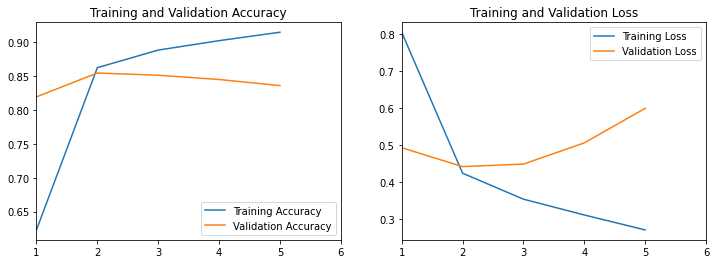

In [69]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()